In [ ]:
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from collections import Counter 

In [ ]:
df = pd.read_csv("datasets.csv")
columns = df.columns 
print(columns)
df.tail()

Index(['word_count', 'word', 'prefix', 'first_prefix', 'second_prefix',
       'suffix', 'second_suffix', 'first_suffix', 'adjective_specificity'],
      dtype='object')


,word_count,word,prefix,first_prefix,second_prefix,suffix,second_suffix,first_suffix,adjective_specificity
972,3,አባሪ,አባ,አ,ባ,ባሪ,ባ,ሪ,0
973,4,ተባረር,ተባ,ተ,ባ,ረር,ረ,ር,1
974,4,ተባረሪ,ተባ,ተ,ባ,ረሪ,ረ,ሪ,0
975,6,አይባረረም,አይ,አ,ይ,ረም,ረ,ም,1
976,5,አትባረሪ,አት,አ,ት,ረሪ,ረ,ሪ,0


In [ ]:
def vectorize(data: pd.DataFrame, prefix: list, suffix: list, target: str) -> dict:
    '''
    Input:
        data: np.array
        prefix: list
        suffix: lsit
        target: str
    Output:
        vectorizer: dict
    '''

    # count frequency of each Amharic letter in each class
    class1_freq = pd.concat([data[data[target] == 1][each] for each in prefix + suffix], axis=0).value_counts().fillna(0)
    class2_freq = pd.concat([data[data[target] == 0][each] for each in prefix + suffix], axis=0).value_counts().fillna(0)

    # load vectorizer json
    vectorizer = {}
    with open('amharic-script.json', 'r') as f:
        am_scripts = json.load(f)
        for script in am_scripts:
            vectorizer.update(script)
    
    # calculate vectorize value for each Amharic letter
    for letter in vectorizer:
        class_1 = class1_freq.get(letter, 0)
        class_2 = class2_freq.get(letter, 0)
        
        if class_1 == class_2 == 0:
            vectorizer[letter] = 0.5
        elif class_1 == 0:
            vectorizer[letter] = 0
        elif class_2 == 0:
            vectorizer[letter] = 1
        else:
            log_ration = np.log2(class_1/class_2)
            sigmoid = 1 / (1 + np.exp(-log_ration))
            vectorizer[letter] = sigmoid
    
    # Vectorize each token
    for i, each in enumerate(prefix):
        data[each] = data[each].str.strip()
        data[each] = data[each].map(vectorizer) * (1 / (i + 1))
    for i, each in enumerate(suffix):
        data[each] = data[each].str.strip()
        data[each] = data[each].map(vectorizer) * (1 / (i + 1))
    
    return vectorizer

prefix = ['first_prefix', 'second_prefix']
suffix = ['first_suffix', 'second_suffix']
vectorizer = vectorize(data = df, prefix=prefix, suffix=suffix, target='adjective_specificity')

# Vectorize other computed features
df['prefix'] = df['prefix'].str.strip()
df['prefix'] = df['prefix'].map(lambda x: vectorizer[x[0]] + (vectorizer[x[1]] * 0.5 if len(x) == 2 else 0))
    
df['suffix'] = df['suffix'].str.strip()
df['suffix'] = df['suffix'].map(lambda x: vectorizer[x[-1]] + (vectorizer[x[0]] * 0.5 if len(x) == 2 else 0))
    
df.head(10)

,word_count,word,prefix,first_prefix,second_prefix,suffix,second_suffix,first_suffix,adjective_specificity
0,2,በላ,0.903813,0.561231,0.342582,0.965780,0.280616,0.685164,1
1,3,በላች,0.903813,0.561231,0.342582,0.342582,0.342582,0.000000,0
2,4,ይበላል,1.244844,0.964229,0.280616,1.090641,0.342582,0.748059,1
3,5,ትበላለች,0.306196,0.025581,0.280616,0.071359,0.071359,0.000000,0
4,2,ብላ,1.054946,0.712363,0.342582,1.041346,0.356182,0.685164,1
5,2,ብይ,1.194478,0.712363,0.482114,1.320410,0.356182,0.964229,0
6,4,በልቷል,0.935261,0.561231,0.374029,1.248059,0.500000,0.748059,1
7,5,በልታለች,0.935261,0.561231,0.374029,0.071359,0.071359,0.000000,0
8,3,ይብላ,1.320410,0.964229,0.356182,1.041346,0.356182,0.685164,1
9,3,ትብላ,0.381762,0.025581,0.356182,1.041346,0.356182,0.685164,0


In [ ]:
df.drop(columns=['word'], inplace=True)

In [ ]:
print(df.shape)
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.shape)
print(df.isnull().sum())
print(df['adjective_specificity'].value_counts())
print(df['adjective_specificity'].value_counts(normalize=True))

(977, 8)
175
(802, 8)
word_count               0
prefix                   0
first_prefix             0
second_prefix            0
suffix                   0
second_suffix            0
first_suffix             5
adjective_specificity    0
dtype: int64
adjective_specificity
1    428
0    374
Name: count, dtype: int64
adjective_specificity
1    0.533666
0    0.466334
Name: proportion, dtype: float64


In [ ]:
df['first_suffix'] = df['first_suffix'].fillna(df['second_suffix'])
print(df.isnull().sum())

word_count               0
prefix                   0
first_prefix             0
second_prefix            0
suffix                   0
second_suffix            0
first_suffix             0
adjective_specificity    0
dtype: int64


In [ ]:
df.corr()

,word_count,prefix,first_prefix,second_prefix,suffix,second_suffix,first_suffix,adjective_specificity
word_count,1.000000,-0.086973,-0.106705,0.009587,-0.169066,-0.235340,-0.118428,-0.113171
prefix,-0.086973,1.000000,0.905488,0.412712,0.322925,0.268008,0.286676,0.563392
first_prefix,-0.106705,0.905488,1.000000,-0.007454,0.238254,0.212360,0.208601,0.472368
second_prefix,0.009587,0.412712,-0.007454,1.000000,0.252798,0.184255,0.236691,0.316932
suffix,-0.169066,0.322925,0.238254,0.252798,1.000000,0.645601,0.955743,0.743648
second_suffix,-0.235340,0.268008,0.212360,0.184255,0.645601,1.000000,0.396220,0.416283
first_suffix,-0.118428,0.286676,0.208601,0.236691,0.955743,0.396220,1.000000,0.735897
adjective_specificity,-0.113171,0.563392,0.472368,0.316932,0.743648,0.416283,0.735897,1.000000


In [ ]:
df.drop(columns=['word_count', 'second_prefix', 'second_suffix'], inplace=True)
df.corr()

,prefix,first_prefix,suffix,first_suffix,adjective_specificity
prefix,1.000000,0.905488,0.322925,0.286676,0.563392
first_prefix,0.905488,1.000000,0.238254,0.208601,0.472368
suffix,0.322925,0.238254,1.000000,0.955743,0.743648
first_suffix,0.286676,0.208601,0.955743,1.000000,0.735897
adjective_specificity,0.563392,0.472368,0.743648,0.735897,1.000000


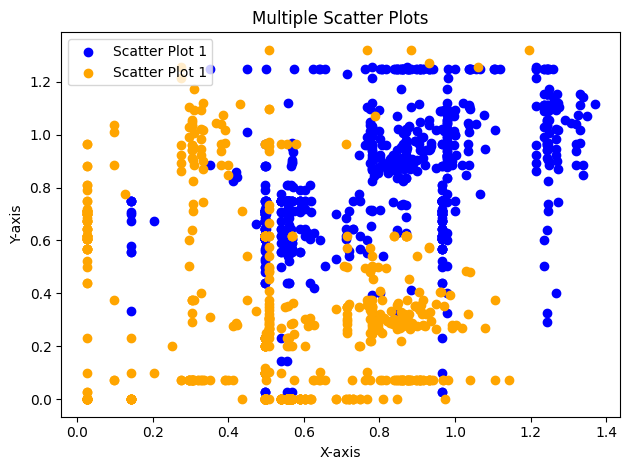

In [ ]:
class1_prefix = pd.concat([df[df['adjective_specificity'] == 1][each] for each in ['prefix', 'first_prefix']], axis=0).values
class1_suffix = pd.concat([df[df['adjective_specificity'] == 1][each] for each in ['suffix', 'first_suffix']], axis=0).values
class2_prefix = pd.concat([df[df['adjective_specificity'] == 0][each] for each in ['prefix', 'first_prefix']], axis=0).values
class2_suffix = pd.concat([df[df['adjective_specificity'] == 0][each] for each in ['suffix', 'first_suffix']], axis=0).values

fig, ax = plt.subplots()

ax.scatter(class1_prefix, class1_suffix, color='blue', label='Scatter Plot 1')
ax.scatter(class2_prefix, class2_suffix, color='orange', label='Scatter Plot 1')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Multiple Scatter Plots')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_train = df['adjective_specificity'].values
X_train = df.drop(columns='adjective_specificity').values
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

clf = LogisticRegression(random_state=1).fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9440993788819876


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff44dff4-4ba1-40f3-adfa-172f20dbf513' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>